# Recurrent Neural Network

## Part 1 - Data Preprocessing

### Importing the libraries

In [232]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from tqdm import tqdm

### Importing the training set

In [233]:
# Read the train data frame
dataset_train = pd.read_csv("data/Google_Stock_Price_Train.csv")
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [234]:
# Convert the value to predict in numpy array
dataset_train["Volume"] = dataset_train["Volume"].str.replace(',', '').astype(float)
volume_train = dataset_train["Volume"].values
volume_train

array([7380500., 5749400., 6590300., ..., 1153800.,  744300., 1770000.])

### Feature Scaling

In [235]:
# Use the normalization transformation to the nparray (MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
volume_train = scaler.fit_transform(volume_train.reshape(-1, 1))
volume_train

array([[0.29525831],
       [0.22993592],
       [0.26361233],
       ...,
       [0.04589107],
       [0.02949139],
       [0.07056868]])

### Creating a data structure with 60 timesteps and 1 output

In [236]:
# For each financial day, you will take into account the stock price of the 60 
# previous days to predict the future stock price build X_train and y_train according to this

x_train = []
y_train = []

for i in range(60, len(volume_train)):
    x_train.append(volume_train[i-60:i, 0])
    y_train.append(volume_train[i, 0])

# X_train and y_train must be numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train = x_train.reshape(-1, 1, 60)

### Building the dataloader

In [237]:
# Convert your data to PyTorch float tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Build the DataLoader with batch of size 32
x_train = DataLoader(dataset=x_train, batch_size=32)
y_train = DataLoader(dataset=y_train, batch_size=32)


## Part 2 - Building and Training the RNN

### Define the RNN model

In [238]:
# Build a class for your model
# The model will contains LSTM layers with 50 memory units (or neurons) and two layers by default,
# Set a dropout regularisation with a rate of 0.2
# Finally add the output Linear layer, the output will be of one dimension (one stock price predicted)

class StockPricePredictor(nn.Module):
    def __init__(self):
        super(StockPricePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=60, hidden_size=50,
                            num_layers=2, dropout=0.2)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(1), 50)
        c0 = torch.zeros(2, x.size(1), 50)
        
        out, _ = self.lstm(x, (h0, c0))  
        out = self.linear(out[:, -1, :])
        return out


### Instantiate the model, loss function, and optimizer

### Fitting the RNN to the Training set

In [239]:
# Set the device to gpu if possible else to cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the RNN with Adam optimizer and the mean squared error as loss function, put the RNN on the device
rnn = StockPricePredictor()
rnn = rnn.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters())

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Joly-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Joly-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


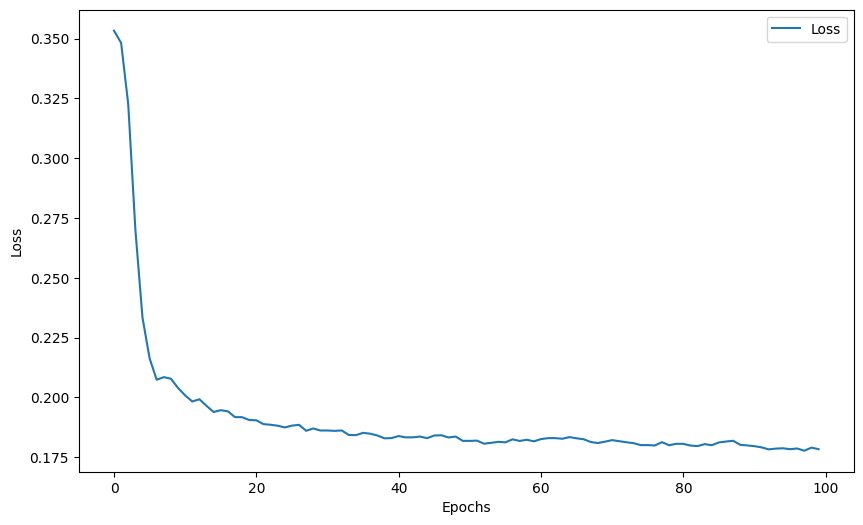

In [240]:
# Train the model using the training set using 100 epochs and a batch size of 32
# This will take some time.

losses = []
rnn.train()
for epoch in tqdm(range(100)):
    loss_t = 0
    for x_data, y_data in zip(x_train, y_train):
        optimizer.zero_grad()
        output = rnn(x_data)
        loss = criterion(output, y_data)
        loss.backward()
        optimizer.step()
        loss_t += loss.item()
    losses.append(loss_t)
        
# Do you see loss value converge ?
# DO you think the model have overfit the training data ?
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(losses, label='Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
plt.legend()
plt.show()

## Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2017

In [241]:
# Read the test data sample and convert to numpy array using Stock Value
dataset_test = pd.read_csv("data/Google_Stock_Price_Test.csv")
dataset_test = dataset_test.rename(columns={'Unnamed: 0': 'Date'})

dataset_test['Volume'] = dataset_test["Volume"].str.replace(',', '').astype(float)
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,1657300.0
1,1/4/2017,788.36,791.34,783.16,786.90,1073000.0
2,1/5/2017,786.08,794.48,785.02,794.02,1335200.0
3,1/6/2017,795.26,807.90,792.20,806.15,1640200.0
4,1/9/2017,806.40,809.97,802.83,806.65,1272400.0


### Getting the predicted stock price of 2017

In [242]:
# Prepare the test input data as the input training data:
# As we use the 60 previous day for each financial day for the training,
# we have to build the same structure for the test data.
# 1. For each financial day of the test set, you need to use the 60 previous day
# values, so you need to concatenate train and test set.
# 2. Use the normalization transformation after the concatenation.
# 3. For each financial day of the test set, get the 60 previous day values
# 4. Create the 3D data : add the new dimension by reshaping the array
# hint : if you get any numpy shape warning, use the method reshape(-1,1) on your numpy array

dataset_test = pd.concat((dataset_train, dataset_test))

volume_test = dataset_test["Volume"].values

scaler = MinMaxScaler(feature_range=(0, 1))
volume_test = scaler.fit_transform(volume_test.reshape(-1, 1))

x_test = []
y_test = []
for i in range(1258, len(volume_test)):
    x_test.append(volume_test[i-60:i, 0])
    y_test.append(volume_test[i, 0])
    
x_test = np.array(x_test)
y_test = np.array(y_test)

x_test = x_test.reshape(-1, 1, 60)

# Convert to PyTorch tensor
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

x_test = DataLoader(dataset=x_test, batch_size=32)
y_test = DataLoader(dataset=y_test, batch_size=32)

### Make predictions on test data

In [246]:
from sklearn.metrics import mean_squared_error
import math

# Get the predictions
predictions = []

rnn.eval()
for x_data in tqdm(x_test):
    output = rnn(x_data)
    predictions.append(output.detach().numpy())


# Inverse transform the predictions
predictions = np.array(predictions)
predictions_flat = predictions.reshape(-1, 1)
predictions_inv = scaler.inverse_transform(predictions_flat)
predictions_inv = predictions_inv.reshape(predictions.shape)


# Calculate RMSE
rmse = math.sqrt(mean_squared_error(volume_test[1258:], predictions_inv.flatten()))
print(f'RMSE: {rmse}')

100%|██████████| 1/1 [00:00<00:00, 500.16it/s]

RMSE: 1501505.5428695541


### Visualising the results

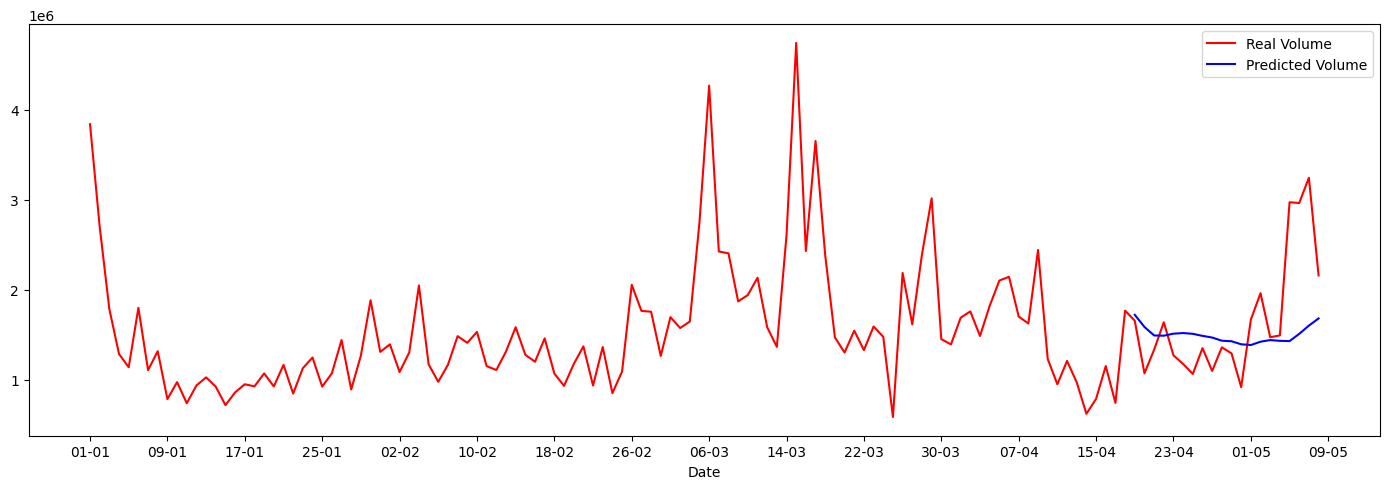

In [268]:
# Build a visualization of the predicted and the real Stock prices of the test set
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

plt.figure(figsize=(14, 5))
plt.plot(dataset_test['Date'].iloc[1150:1280], dataset_test['Volume'].iloc[1150:1280], linestyle = '-', color = 'red' , label = 'Real Volume')

plt.plot(dataset_test['Date'].iloc[1258:1280], predictions_inv.flatten(), color = 'blue', label = 'Predicted Volume')

plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(DateFormatter('%d-%m'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.tight_layout()

plt.legend()
plt.show()

Comment the results. How can you improve your model ? What are the different parameters you can modify ? Implement them. Do you see any change ?

Pour améliorer le modèle on pourrait réentrainer notre modèle une fois qu'on a obtenu la vraie valeur du jour afin de maintenir une tendance constante et éviter les variations importantes dans le temps. Il est aussi possible de jouer sur les hyperparamètres du modèle.